# 6.1 Бустинг

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

In [0]:
df = pd.read_csv('https://github.com/samarthjmodi/Telecom-Customer-Churn/raw/master/Churn.csv')

In [0]:
categorical_feature_names = [
    'gender', 'Partner', 'Dependents', 'PhoneService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PaperlessBilling', 'MultipleLines', 'InternetService',
    'Contract', 'PaymentMethod'
]

target_feature_name = 'Churn'

In [4]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
df = df.drop('customerID', axis='columns')

for cat_feature_name in categorical_feature_names:
    df.loc[:, cat_feature_name] = df.loc[:, cat_feature_name].astype('category').cat.codes
    
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(df.TotalCharges.mean())

In [0]:
X = df.drop(target_feature_name, axis='columns').copy()
y = (df[target_feature_name] == 'Yes')

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=228)

__*Бустинг*__ $-$ процесс итеративного построения ансамбля моделей, в котором изначально построенный алгоритм $b_1(x)$ дополняется семейством новых $b_2(x), \dots, b_T(x)$. При этом решение принимается взвешенным голосованием c весами у каждого алгоритма $\alpha_i$:

$$ a(x) = sign \Big( \sum_{i=1}^T \alpha_i b_i(x) \Big) $$

В Scikit-Learn реализованы два алгоритма с бустингом: AdaBoost и Gradient Boosting. Рассмотрим каждый из них подробнее.

### AdaBoost
AdaBoost расшифровывается как адаптивный бустинг. Этот алгоритм отличителен тем, что веса всех алгоритмов ансамбля меняются во время его построения. Алгоритм его построения определен ниже.

Пусть требуется построить ансамбль из $T$ алгоритмов, у каждого объекта $\{ x_1, ..., x_\ell \}$ есть вес $w_i$, изначально равный $1 / \ell$, все их множество будем обозначать как $W$. Тогда выполняем следующий итеративный процесс для каждого $t = 1, ..., T$:

1. Обучаем базовый алгоритм: $$b_t := \arg \min_b N(b, W), \text{ где } N(b, W) = \sum_{i=1}^\ell w_i \big[ b(x_i) \neq y_i\big]$$
Веса $W$ предполагаются нормированными: $\forall i: w_i > 0, \sum_{i=1}^\ell w_i = 1$
2. Подсчитываем вес этого алгоритма в ансамбле: $$\alpha_t := \frac{1}{2} \ln \frac{1 - N(b_t, W)}{N(b_t, W)}$$
3. Обновляем веса объектов: $$w_i := w_i \exp(- \alpha_t y_i b_t(x_i))$$
4. Отнормировать веса объектов: $$w_i := \frac{w_i}{\sum_j w_j} $$

Важно: AdaBoost внутри себя оптимизирует количество неправильно классифицированных объектов.

In [51]:
clf = AdaBoostClassifier(algorithm='SAMME')
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

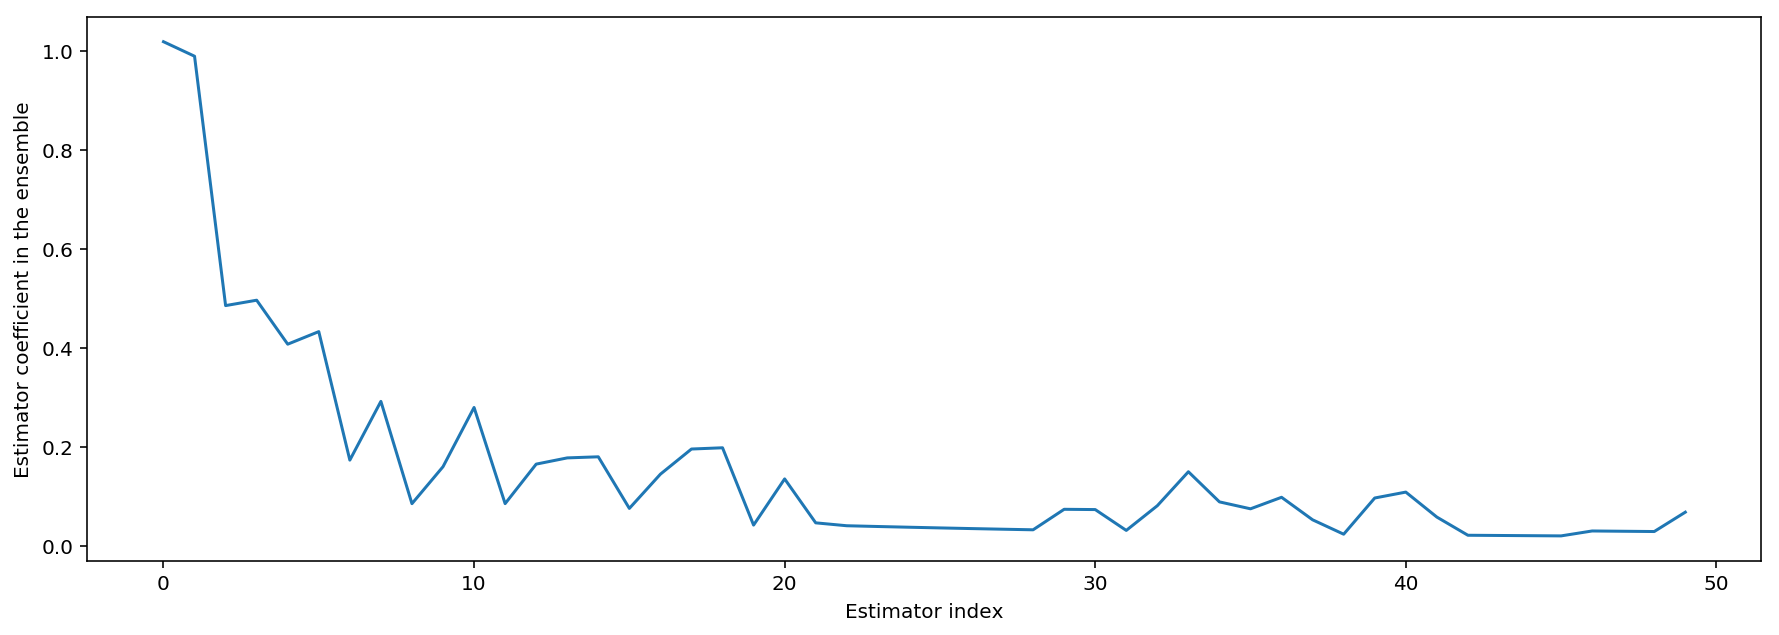

In [52]:
plt.figure(figsize=(15, 5))
plt.xlabel('Estimator index')
plt.ylabel('Estimator coefficient in the ensemble')
plt.plot(clf.estimator_weights_);

In [53]:
clf.score(X_valid, y_valid)

0.7967064168086314

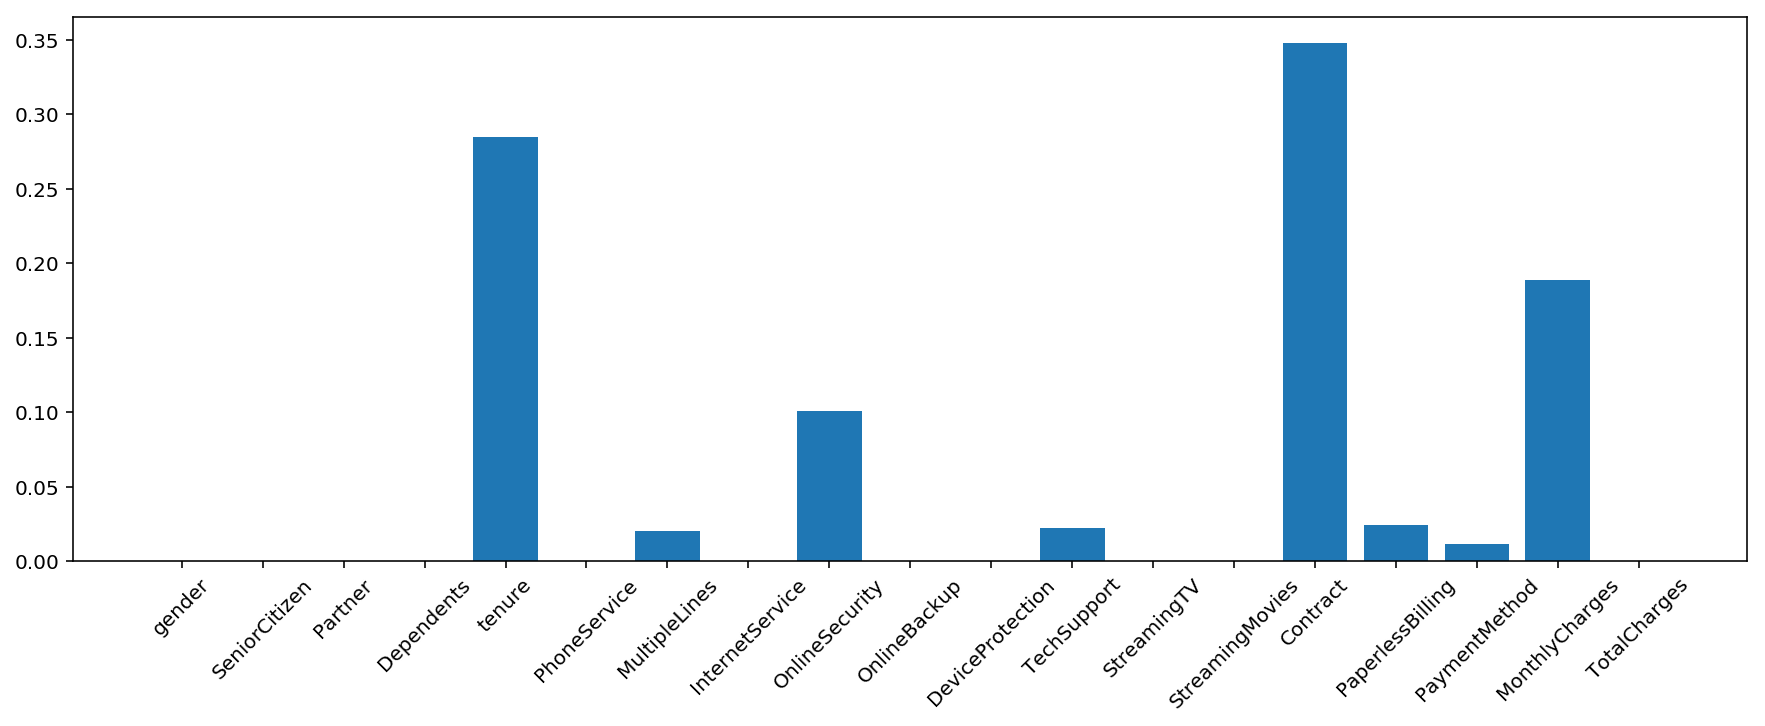

In [47]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
plt.bar(X.columns, clf.feature_importances_);

Сравним как падает качество при удалении первого дерева из ансамбля в AdaBoost и в RandomForest.

In [12]:
clf.score(X_valid, y_valid)

0.7967064168086314

In [13]:
clf.estimators_ = clf.estimators_[1:]
clf.estimator_weights_ = clf.estimator_weights_[1:]

clf.score(X_valid, y_valid)

0.7524134014764339

In [63]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [64]:
rf.score(X_valid, y_valid)

0.7910278250993753

In [65]:
rf.estimators_ = rf.estimators_[1:]

rf.score(X_valid, y_valid)

0.7904599659284497

### Gradient Boosting

В отличие от адаптивного бустинга, градиентный бустинг минимизирует произвольную функцию потерь. Рассмотрим принцип его работы.  
Пусть дана функция потерь $\mathcal{L}$. Для всей выборки функция потерь для алгоритма $f$ опредена следующим образом: $$Q(f) = \sum_{i=1}^{\ell} \mathcal{L}(f(x_i), y_i)$$.  
Если бы находили ее минимум градиентным методом, то поступали бы так:

$$ f_0 := \text{начальное приближение} $$
$$ f_{T, i} := f_{T-1, i} - \alpha g_i, $$
где $g_i = \mathcal{L}' (f(x_i), y_i), i = 1, \dots, \ell - $ компоненты градента функции потерь, а $\alpha\ - $ шаг градиента.  
Это очень похоже на одну итерацию бустинга, в котором уже закреплены первые $T-1$ алгоритмов и ищется следующий.

$$ f_{T, i} := f_{T-1, i} + \alpha b_(x_i) $$

Поэтому *идея градиентного бустинга* $-$ приближать антиградиент функции потерь $Q$:

$$ b_T := \arg \min_b \sum_{i=1}^\ell (b(x_i) - g_i)^2 $$

__Важно__: градиент здесь определен не по признакам, а по объектам обучающей выборки. Другими словами, этот градиент описывает то, как текущий ансамбль ошибается на объектах выборки. Каждое следующее дерево исправляет ошибки _всех_ предыдущих.

Алгоритм:
0. $f_i := 0, i=1, \dots, \ell$
1. Для $t = 1, \dots, T$:  
    2. $b_t := \arg \min_b (b(x_i) + \mathcal{L}'(f_i, x_i))^2$
    3. $\alpha_t := \arg \min_{\alpha > 0} \mathcal{L} (f_i + \alpha b_t(x_i), y_i)$
    4. $f_i := f_i + \alpha_t b_t(x_i), i = 1, \dots, \ell$

In [103]:
gb = GradientBoostingClassifier(n_estimators=1000, 
                                subsample=0.9, learning_rate=0.01)
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

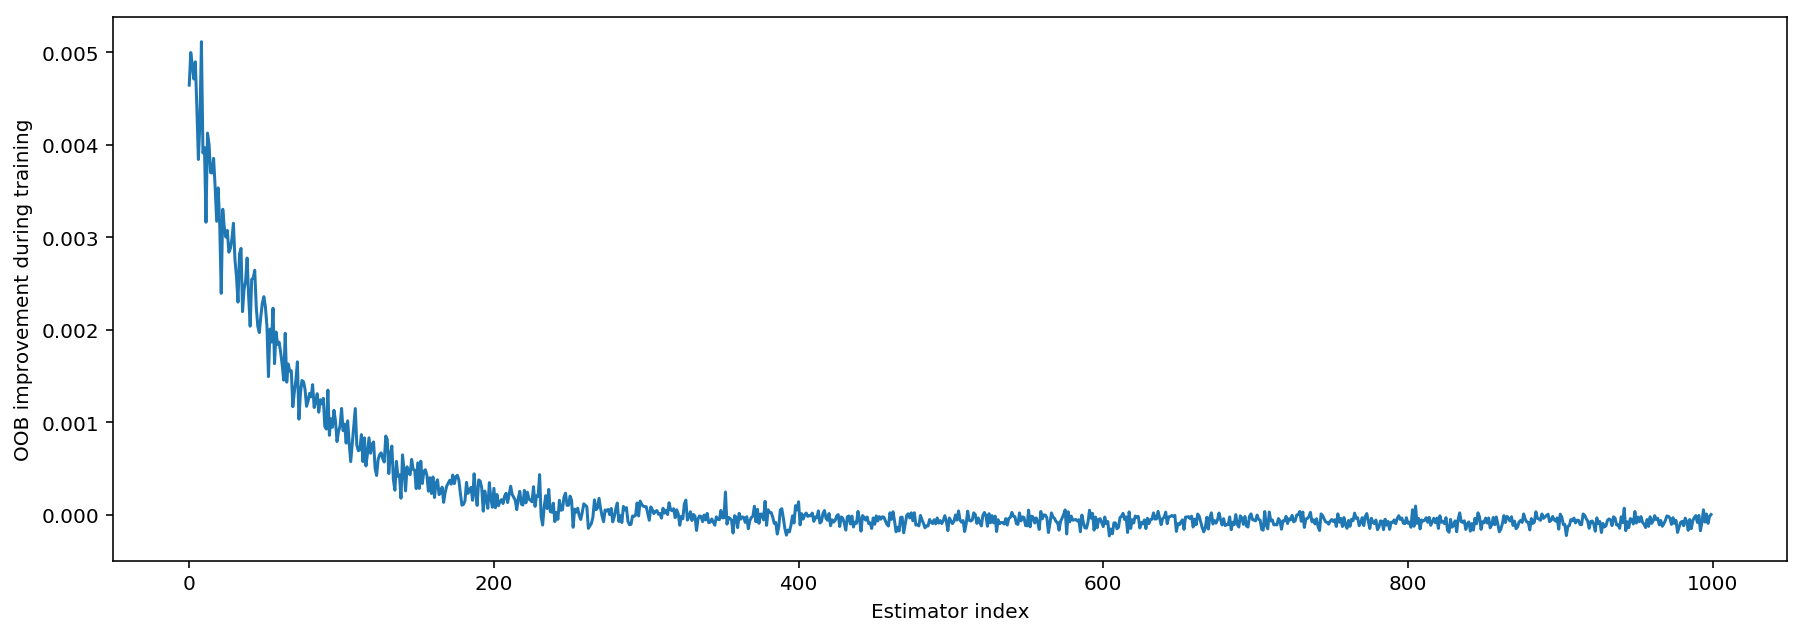

In [104]:
plt.figure(figsize=(15, 5))
plt.xlabel('Estimator index')
plt.ylabel('OOB improvement during training')
plt.plot(gb.oob_improvement_);

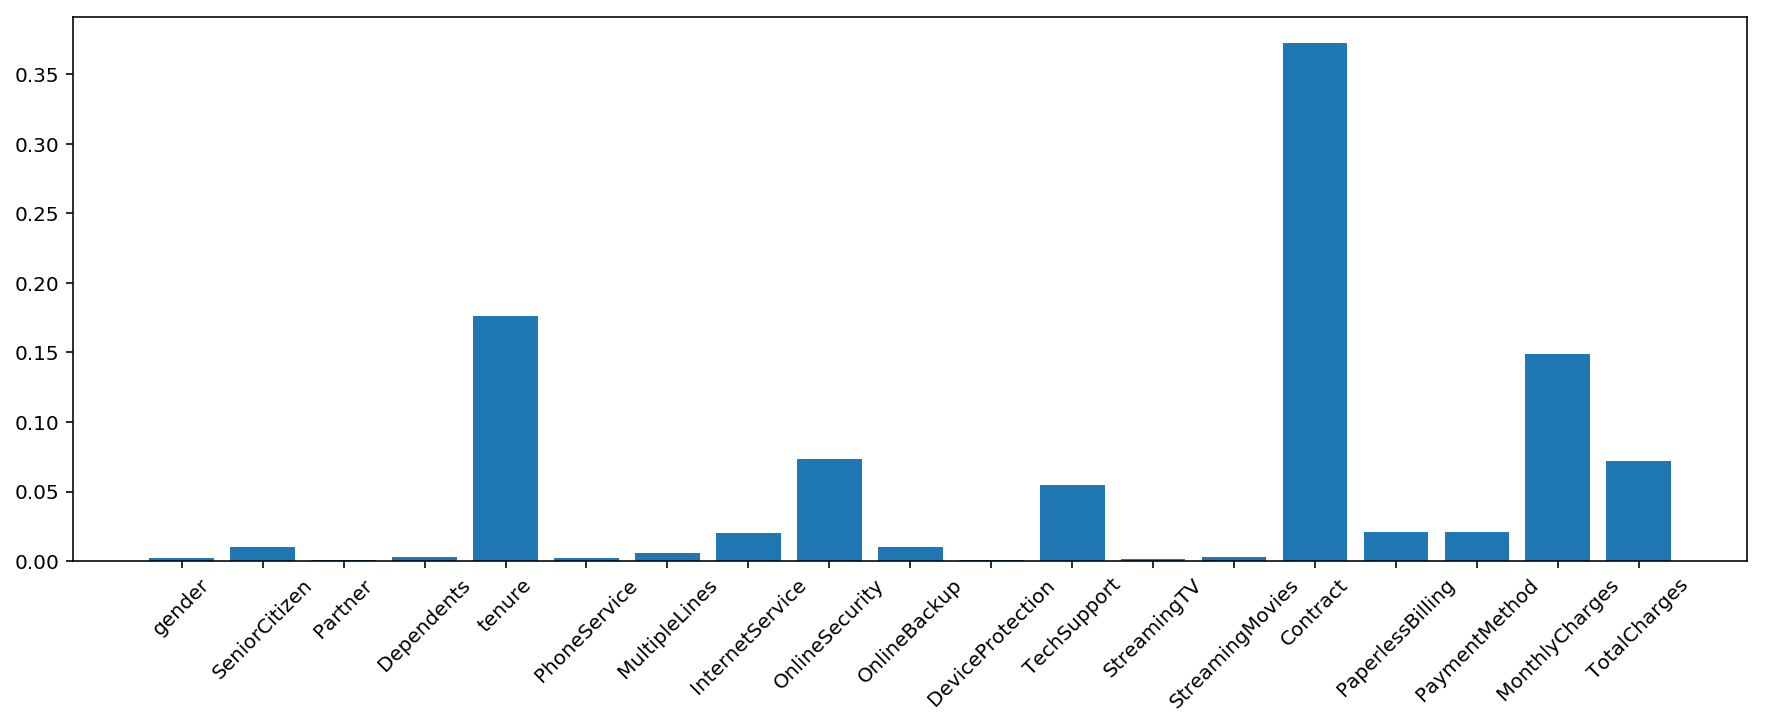

In [105]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
plt.bar(X.columns, gb.feature_importances_);

In [106]:
gb.score(X_valid, y_valid)

0.8023850085178875

In [107]:
gb.estimators_ = gb.estimators_[1:]

gb.score(X_valid, y_valid)

0.8023850085178875